In [1]:
import numpy as np
import matplotlib.pyplot as plt

EXPAND = {'p': 'Position', 's': 'Speed', 'a': 'Acceleration', 'j': 'Jerk'}

def curve_gradient(input_traj, ts):
        grad=np.diff(input_traj) / ts
        grad=np.append(grad, grad[-1])
        return grad

def read_traj(file_path, ts):
    data_leader_pos = np.loadtxt(open(file_path + 'Leading Position.csv', "rb"), delimiter=",", skiprows=0)
    data_leader_spd = np.loadtxt(open(file_path + 'Leading Speed.csv', "rb"), delimiter=",", skiprows=0)
    data_leader_acc = np.loadtxt(open(file_path + 'Leading Acc.csv', "rb"), delimiter=",", skiprows=0)

    data_follower_pos = np.loadtxt(open(file_path + 'Following Position.csv', "rb"), delimiter=",", skiprows=0)
    data_follower_spd = np.loadtxt(open(file_path + 'Following Speed.csv', "rb"), delimiter=",", skiprows=0)
    data_follower_acc = np.loadtxt(open(file_path + 'Following Acc.csv', "rb"), delimiter=",", skiprows=0)

    leader_vec = TrajVector(sample_time_step = ts)
    leader_vec.load(data_leader_pos, data_leader_spd, data_leader_acc)

    follower_vec = TrajVector(sample_time_step = ts)
    follower_vec.load(data_follower_pos, data_follower_spd, data_follower_acc)
    
    return leader_vec, follower_vec    
    

# basic class to store trajectory data with position and speed
class VehProfile:
    def __init__(self, time_step, position, speed, acceleration, jerk = []):
        self.time_step = time_step
        self.position = position
        self.speed = speed
        self.acceleration = acceleration
        self.jerk = jerk
        self.no_jerk = False
        if len(jerk) == 0:
            self.jerk = np.zeros(position.shape)
            self.no_jerk = True
            
        self.sample_points = len(self.position)
    
    def show(self):
        t = np.arange(0, self.time_step * self.sample_points, self.time_step)
        if d_type == 'p':          
            plt.plot(t, self.position)
        if d_type == 's':
            plt.plot(t, self.speed)
        if d_type == 'a':          
            plt.plot(t, self.acceleration)
        if d_type == 'j':
            plt.plot(t, self.jerk)
        plt.xlabel('Time')
        plt.ylabel(EXPAND[d_type])
        plt.show()
        
        
class Traj:
    def __init__(self, veh_profile):
        self.position = veh_profile.position
        self.speed = veh_profile.speed
        self.acceleration = veh_profile.acceleration
        self.jerk = veh_profile.jerk
        self.no_jerk = veh_profile.no_jerk
        self.sample_points = veh_profile.sample_points
        self.time_step = veh_profile.time_step
    
    def plot(self, d_type):
        t = np.arange(0, self.time_step * self.sample_points, self.time_step)
        if d_type == 'p':          
            plt.plot(t, self.position)
        if d_type == 's':
            plt.plot(t, self.speed)
        if d_type == 'a':          
            plt.plot(t, self.acceleration)
        if d_type == 'j':
            plt.plot(t, self.jerk)
    
    def show(self, d_type = 'p'):
        self.plot(d_type)
        plt.xlabel('Time')
        plt.ylabel(EXPAND[d_type])
        plt.show()
        
    def distance(self, another_traj):
        position_error = np.sqrt(np.square(self.position - another_traj.position).mean())
        speed_error = np.sqrt(np.square(self.speed - another_traj.speed).mean())
        acceleration_error = np.sqrt(np.square(self.acceleration - another_traj.acceleration).mean())
        return position_error, speed_error, acceleration_error

class TrajPair:
    def __init__(self, traj_leader, traj_follower):
        self.leader = traj_leader
        self.follower = traj_follower
        self.sample_points = traj_leader.sample_points
        self.time_step = traj_leader.time_step
    
    def show(self, d_type = 'p'):
        t = np.arange(0, self.time_step * self.sample_points, self.time_step)
        self.leader.plot(d_type)
        self.follower.plot(d_type)
        plt.xlabel('Time')
        plt.ylabel(EXPAND[d_type])
        plt.legend(['Leader', 'Follower'])
        plt.show()
        
class TrajVector:
    def __init__(self, sample_time_step):
        self.time_step = sample_time_step
        self.veh = {}
        self.num_veh = 0
        self.sample_id = -1
    def save(self, path_name):
        np.savetxt(path_name + ' Position.csv', self.position_vector, delimiter = ",", fmt='%.4f')
        np.savetxt(path_name + ' Speed.csv', self.speed_vector, delimiter = ",", fmt='%.4f')
        np.savetxt(path_name + ' Acc.csv', self.acceleration_vector, delimiter = ",", fmt='%.4f')
        if not self.no_jerk:
            np.savetxt(path_name + ' Jerk.csv', self.jerk_vector, delimiter = ",", fmt='%.4f')
        
    def load(self, position_vector, speed_vector, acceleration_vector, jerk_vector = []):
        self.sample_points = position_vector.shape[0]
        self.num_veh = position_vector.shape[1]
        self.position_vector = position_vector
        self.speed_vector = speed_vector
        self.acceleration_vector = acceleration_vector
        self.no_jerk = False
        if len(jerk_vector) == 0:
            jerk_vector = np.zeros(position_vector.shape)
            self.no_jerk = True
        self.jerk_vector = jerk_vector
        self.veh = {}
        if self.no_jerk:  
            for i in range(self.num_veh):
                self.veh[i] = Traj(VehProfile(self.time_step, 
                                          position_vector[:,i], 
                                          speed_vector[:,i], 
                                          acceleration_vector[:, i], 
                                          []))
        else:
            for i in range(self.num_veh):
                self.veh[i] = Traj(VehProfile(self.time_step, 
                                              position_vector[:,i], 
                                              speed_vector[:,i], 
                                              acceleration_vector[:, i], 
                                              jerk_vector[:,i]))
   
    
    def traj_to_vec(self):
        self.position_vector = np.zeros([self.sample_points, self.num_veh])
        self.speed_vector = np.zeros([self.sample_points, self.num_veh])
        self.acceleration_vector = np.zeros([self.sample_points, self.num_veh])
        self.jerk_vector = np.zeros([self.sample_points, self.num_veh])
        for i in range(self.num_veh):
            self.position_vector[:,i] = self.veh[i].position
            self.speed_vector[:,i] = self.veh[i].speed
            self.acceleration_vector[:,i] = self.veh[i].acceleration
            self.jerk_vector[:,i] = self.veh[i].jerk
            
    def show(self, n, d_type = 'p'):
        self.veh[n].show(d_type)
        
    def distance(self, another_vec):
        if self.num_veh != another_vec.num_veh \
        or self.time_step != another_vec.time_step \
        or self.sample_points != another_vec.sample_points \
        or self.veh[0].position.shape != another_vec.veh[0].position.shape:
            raise ValueError('Trajectory Dimension Not Matching')
        
        position_error = 0
        speed_error = 0
        acceleration_error = 0
        # jerk_error = 0
        
        if self.sample_id < 0:     
            for i in range(self.num_veh):
                position_error += np.sqrt(np.square(self.veh[i].position - another_vec.veh[i].position).mean())
                speed_error += np.sqrt(np.square(self.veh[i].speed - another_vec.veh[i].speed).mean())
                acceleration_error += np.sqrt(np.square(self.veh[i].acceleration - another_vec.veh[i].acceleration).mean())
                # jerk_error += np.sqrt(np.square(self.veh[i].jerk - another_vec.veh[i].jerk).mean())
                 
               
            
        
        else:
            position_error = np.sqrt(np.square(self.veh[0].position - another_vec.veh[self.sample_id].position).mean())
            speed_error = np.sqrt(np.square(self.veh[0].speed - another_vec.veh[self.sample_id].speed).mean())
            acceleration_error = np.sqrt(np.square(self.veh[0].acceleration - another_vec.veh[self.sample_id].acceleration).mean())
            # jerk_error = np.sqrt(np.square(self.veh[0].jerk - another_vec.veh[self.sample_id].jerk).mean())
            
        
        # return (position_error, speed_error, acceleration_error, jerk_error)
        return (position_error, speed_error, acceleration_error)


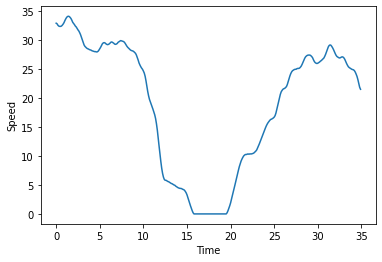

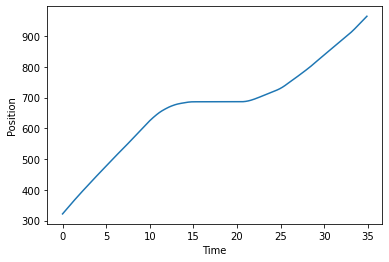

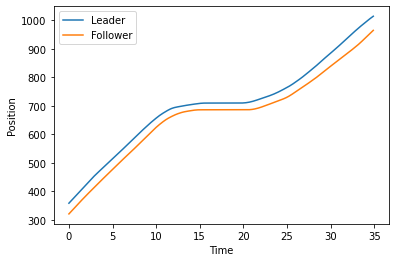

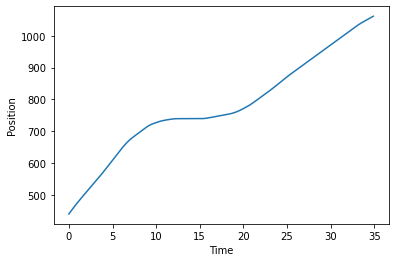

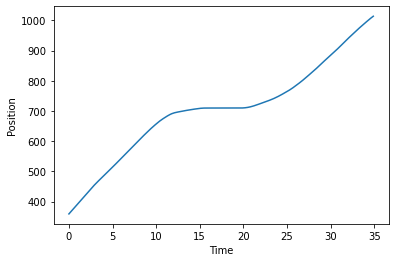

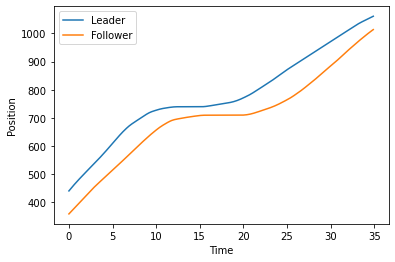

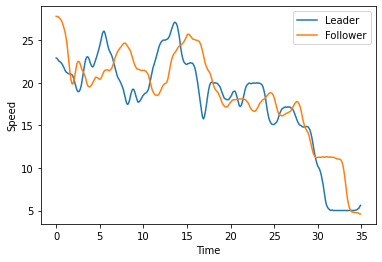

In [3]:
### Test module

if __name__ == '__main__':
    # Read a csv file as numpy matrix: return ndarray          
    file_path = '../data/NGSIM/'          

    data_leader_pos = np.loadtxt(open(file_path + 'Leading Position.csv', "rb"), delimiter=",", skiprows=0)
    data_leader_spd = np.loadtxt(open(file_path + 'Leading Speed.csv', "rb"), delimiter=",", skiprows=0)
    data_leader_acc = np.loadtxt(open(file_path + 'Leading Acc.csv', "rb"), delimiter=",", skiprows=0)
    data_follower_pos = np.loadtxt(open(file_path + 'Following Position.csv', "rb"), delimiter=",", skiprows=0)
    data_follower_spd = np.loadtxt(open(file_path + 'Following Speed.csv', "rb"), delimiter=",", skiprows=0)
    data_follower_acc = np.loadtxt(open(file_path + 'Following Acc.csv', "rb"), delimiter=",", skiprows=0)
    
    lead_traj = Traj(VehProfile(0.1, data_leader_pos[:,1], data_leader_spd[:,1], data_leader_acc[:,1]))
    lead_traj.show('s')
    
    follow_traj = Traj(VehProfile(0.1, data_follower_pos[:,1], data_follower_spd[:,1], data_follower_acc[:,1]))
    follow_traj.show()
    
    a_pair = TrajPair(lead_traj, follow_traj)
    a_pair.show()
    
    leader_vec = TrajVector(sample_time_step = 0.1)
    leader_vec.load(data_leader_pos, data_leader_spd, data_leader_acc)
    leader_vec.show(0)
    
    follower_vec = TrajVector(sample_time_step = 0.1)
    follower_vec.load(data_follower_pos, data_follower_spd, data_follower_acc)
    follower_vec.show(0)
    
    TrajPair(leader_vec.veh[0], follower_vec.veh[0]).show()
    TrajPair(leader_vec.veh[10], follower_vec.veh[10]).show('s')
    
